# Phase 0 : Filtrage des données DVF


In [1]:
import numpy as np

In [2]:
import pandas as pd
import os

# Chargement
df = pd.read_csv("../raw_data/ValeursFoncieres-2022.txt", sep='|', low_memory=False)

# Harmonisation
df['Commune'] = df['Commune'].str.upper()

# Filtrage LILLE
df_lille = df[
    (df['Commune'] == 'LILLE') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Filtrage BORDEAUX
df_bordeaux = df[
    (df['Commune'] == 'BORDEAUX') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Conversion en float
for df_city in [df_lille, df_bordeaux]:
    df_city['Valeur fonciere'] = df_city['Valeur fonciere'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)
    df_city['Surface reelle bati'] = df_city['Surface reelle bati'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)

# Calcul du prix au m²
df_lille['prix_m2'] = df_lille['Valeur fonciere'] / df_lille['Surface reelle bati']
df_bordeaux['prix_m2'] = df_bordeaux['Valeur fonciere'] / df_bordeaux['Surface reelle bati']

# Export
os.makedirs("../data", exist_ok=True)
df_lille.to_csv("../data/lille_2022.csv", index=False)
df_bordeaux.to_csv("../data/bordeaux_2022.csv", index=False)

print("Export terminé.")

Export terminé.


# Phase 1 — Modélisation du prix au m² à Lille (2022) pour les logements de 4 pièces

In [3]:
df_lille = pd.read_csv("../data/lille_2022.csv")

In [4]:
df_lille.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11354 entries, 0 to 11353
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Identifiant de document     0 non-null      float64
 1   Reference document          0 non-null      float64
 2   1 Articles CGI              0 non-null      float64
 3   2 Articles CGI              0 non-null      float64
 4   3 Articles CGI              0 non-null      float64
 5   4 Articles CGI              0 non-null      float64
 6   5 Articles CGI              0 non-null      float64
 7   No disposition              11354 non-null  int64  
 8   Date mutation               11354 non-null  object 
 9   Nature mutation             11354 non-null  object 
 10  Valeur fonciere             11354 non-null  float64
 11  No voie                     11248 non-null  float64
 12  B/T/Q                       652 non-null    object 
 13  Type de voie                113

In [5]:
df_lille.columns

Index(['Identifiant de document', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'prix_m2'],
      dtype='object')

In [6]:
df_lille.describe()

c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Valeur fonciere,No voie,...,4eme lot,5eme lot,Nombre de lots,Code type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture speciale,Surface terrain,prix_m2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11354.000000,1.135400e+04,11248.000000,...,106.000000,50.000000,11354.000000,11354.000000,0.0,11354.000000,11354.000000,0.0,3672.000000,1.135400e+04
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.003963,6.906027e+05,199.709015,...,84.905660,94.180000,0.957812,2.472521,NaN,42.131760,1.323146,NaN,236.449619,inf
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062833,2.354745e+06,1072.930117,...,373.543662,346.065388,0.899357,0.789471,NaN,175.379622,1.666542,NaN,629.515964,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00,1.000000,...,3.000000,7.000000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,4.000000,1.347709e-04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.545000e+05,13.000000,...,7.000000,9.000000,0.000000,2.000000,NaN,0.000000,0.000000,NaN,78.000000,3.851514e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.275175e+05,35.000000,...,9.000000,19.000000,1.000000,2.000000,NaN,22.000000,1.000000,NaN,124.000000,1.685750e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.651500e+05,91.000000,...,31.000000,32.000000,1.000000,3.000000,NaN,59.000000,2.000000,NaN,221.000000,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,6.180000e+07,9999.000000,...,3004.000000,2256.000000,17.000000,4.000000,NaN,10945.000000,14.000000,NaN,18147.000000,inf


In [7]:
df_lille.describe(exclude= np.number)

,Date mutation,Nature mutation,B/T/Q,Type de voie,Code voie,Voie,Commune,Section,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,Type local,Nature culture
count,11354,11354,652,11328,11354,11354,11354,11354,2442,613,75,19,16,11354,3672
unique,274,1,12,22,1041,1022,1,191,1583,296,30,6,4,4,4
top,11/08/2022,Vente,B,RUE,0657,BAYARD,LILLE,C,"319,20","326,40","328,50","326,80","273,50",Dépendance,S
freq,213,11354,475,9337,273,273,11354,481,11,11,11,11,11,4641,3467


In [8]:
df_lille['Nombre pieces principales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11354 entries, 0 to 11353
Series name: Nombre pieces principales
Non-Null Count  Dtype  
--------------  -----  
11354 non-null  float64
dtypes: float64(1)
memory usage: 88.8 KB


In [9]:
df_lille['Nombre pieces principales'].astype('int')

0        5
1        3
2        0
3        0
4        0
        ..
11349    0
11350    0
11351    4
11352    4
11353    4
Name: Nombre pieces principales, Length: 11354, dtype: int64

## Appart & maison de 4 pieces

In [10]:
df_lille_filtered = df_lille[df_lille['Nombre pieces principales'] == 4]

In [11]:
df_lille_filtered['Type local'].unique()

array(['Maison', 'Appartement'], dtype=object)

In [12]:
df_maison = df_lille_filtered[df_lille_filtered['Type local'] == 'Maison']

In [13]:
df_appart = df_lille_filtered[df_lille_filtered['Type local'] == 'Appartement']

## 4.

In [14]:
required_columns = ['Surface reelle bati', 'Nombre pieces principales',
'Type local','Surface terrain','Nombre de lots','prix_m2']

In [15]:
df_maison_ = df_maison[required_columns]

In [16]:
df_maison_.shape

(354, 6)

In [17]:
df_maison_.describe(exclude=np.number)

,Type local
count,354
unique,1
top,Maison
freq,354


In [18]:
df_maison_.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,prix_m2
count,354.000000,354.0,340.000000,354.000000,354.000000
mean,84.310734,4.0,142.638235,0.039548,3003.594635
std,19.462888,0.0,84.800103,0.195171,1116.900260
min,44.000000,4.0,31.000000,0.000000,144.144144
25%,71.000000,4.0,84.750000,0.000000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,2847.948718
75%,95.000000,4.0,175.250000,0.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,9192.073171


In [19]:
df_appart_ = df_appart[required_columns]

In [20]:
df_appart_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 23 to 11351
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        435 non-null    float64
 1   Nombre pieces principales  435 non-null    float64
 2   Type local                 435 non-null    object 
 3   Surface terrain            49 non-null     float64
 4   Nombre de lots             435 non-null    int64  
 5   prix_m2                    435 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 23.8+ KB


## 6. **Nettoyer les données** :
    - Supprimer les lignes avec valeurs manquantes sur les colonnes utilisées
    - Identifier et retirer les valeurs aberrantes (prix au m² trop faible ou trop élevé)

In [21]:
df_maison_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
prix_m2                      False
dtype: bool

In [22]:
df_maison_.dropna(axis=0, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_3068\2148659308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maison_.dropna(axis=0, inplace=True)


In [23]:
df_maison_.shape

(340, 6)

In [24]:
df_appart_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
prix_m2                      False
dtype: bool

In [25]:
df_appart_.dropna(axis=0,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_3068\1012287777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appart_.dropna(axis=0,inplace=True)


In [26]:
df_appart_.shape

(49, 6)

## Outliers

In [27]:
def drop_outliers(df:pd.DataFrame, column:str):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR=q3-q1

    without_outliers = df[((df[column]>(q1-1.5*IQR)) & (df[column]<(q3+1.5*IQR)))]
    return without_outliers
    


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

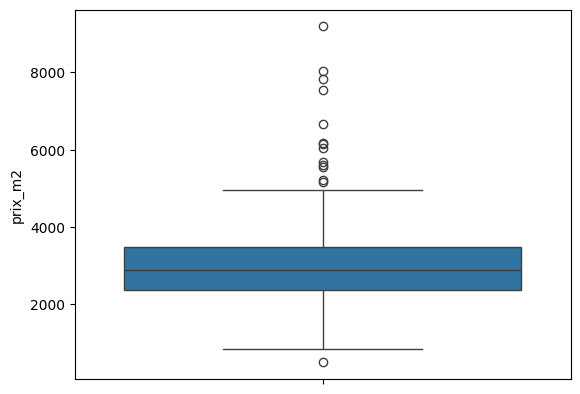

In [29]:
sns.boxplot(df_maison_['prix_m2'])
plt.show()

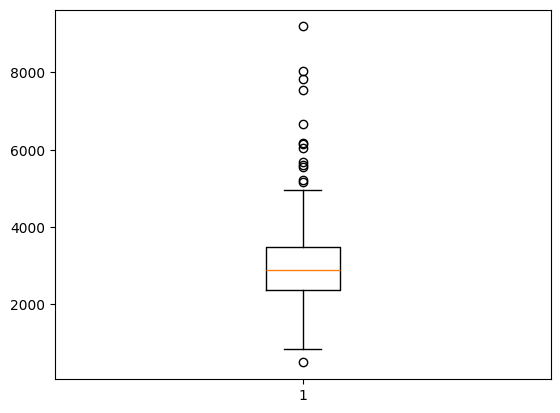

In [30]:
plt.boxplot(df_maison_['prix_m2'])
plt.show()

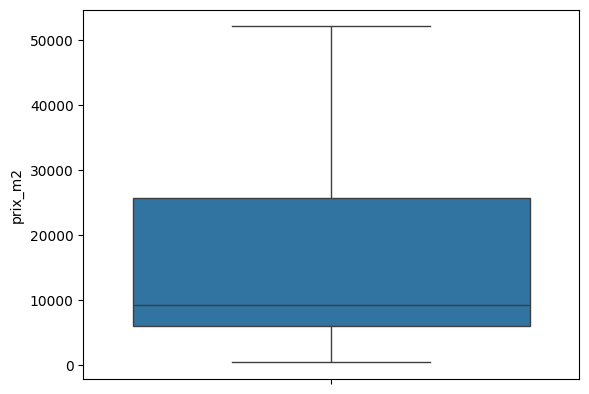

In [31]:
sns.boxplot(df_appart_['prix_m2'])
plt.show()

In [32]:
df_maison_to_process = drop_outliers(df_maison_, 'prix_m2')
df_maison_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,prix_m2
18,165.0,4.0,Maison,121.0,0,1848.484848
65,64.0,4.0,Maison,127.0,0,3545.312500
161,70.0,4.0,Maison,192.0,0,2941.285714
168,62.0,4.0,Maison,96.0,0,2572.580645
176,72.0,4.0,Maison,135.0,0,3609.722222


In [33]:
df_appart_to_process = drop_outliers(df_appart_, 'prix_m2')
df_appart_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,prix_m2
394,116.0,4.0,Appartement,155.0,0,1465.517241
575,170.0,4.0,Appartement,221.0,0,3058.823529
940,53.0,4.0,Appartement,105.0,0,27735.849057
1249,65.0,4.0,Appartement,176.0,0,9230.769231
1251,65.0,4.0,Appartement,176.0,0,9230.769231


### Appart

In [34]:
df_appart_num_fea = df_appart_to_process.drop('Type local', axis=1)

In [35]:
df_appart_num_fea.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,prix_m2
count,49.000000,49.0,49.000000,49.0,49.000000
mean,85.204082,4.0,232.714286,0.0,17667.561781
std,26.742584,0.0,193.109533,0.0,15911.591246
min,18.000000,4.0,43.000000,0.0,416.666667
25%,72.000000,4.0,136.000000,0.0,6000.000000
50%,84.000000,4.0,176.000000,0.0,9230.769231
75%,94.000000,4.0,306.000000,0.0,25654.761905
max,170.000000,4.0,1207.000000,0.0,52065.934066


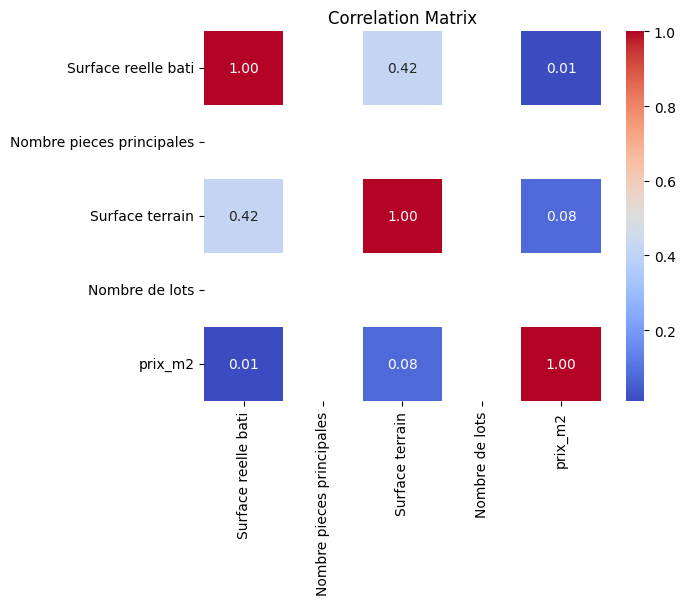

In [36]:
sns.heatmap(df_appart_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'prix_m2'}>, <Axes: >]], dtype=object)

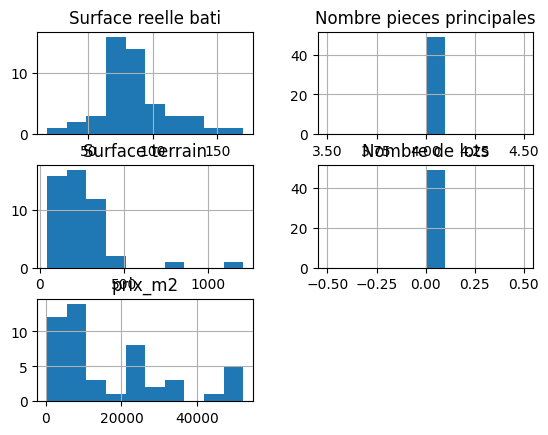

In [37]:
df_appart_num_fea.hist()

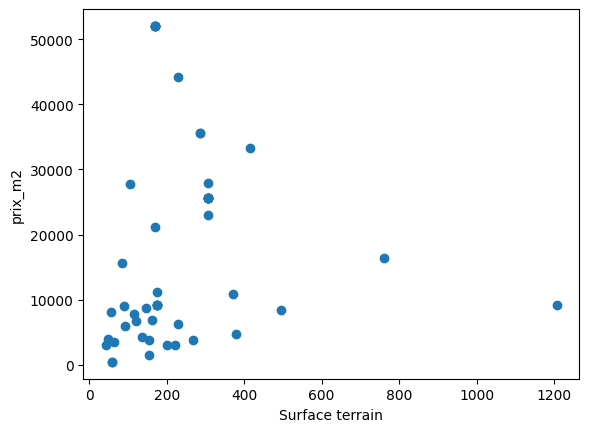

In [38]:
plt.scatter(df_appart_num_fea['Surface terrain'],df_appart_num_fea['prix_m2'])
plt.xlabel('Surface terrain')
plt.ylabel('prix_m2')
plt.show()

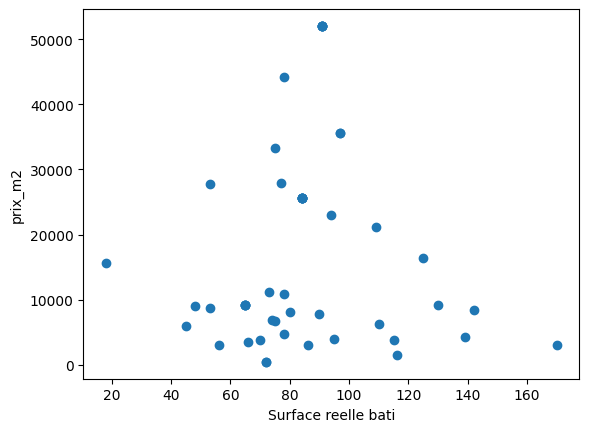

In [39]:
plt.scatter(df_appart_num_fea['Surface reelle bati'],df_appart_num_fea['prix_m2'])
plt.xlabel('Surface reelle bati')
plt.ylabel('prix_m2')
plt.show()

### Maison

In [40]:
df_maison_num_fea = df_maison_to_process.drop('Type local', axis=1)

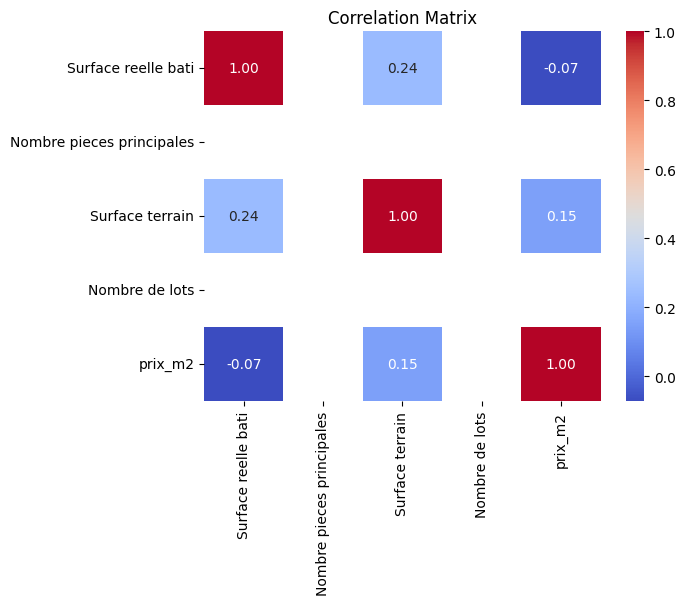

In [41]:
sns.heatmap(df_maison_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [42]:
#df_numeric = df_maison_to_process.select_dtypes(include='number')

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'prix_m2'}>, <Axes: >]], dtype=object)

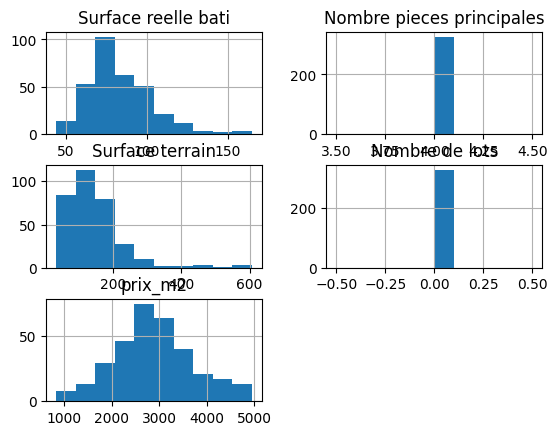

In [43]:
df_maison_num_fea.hist()

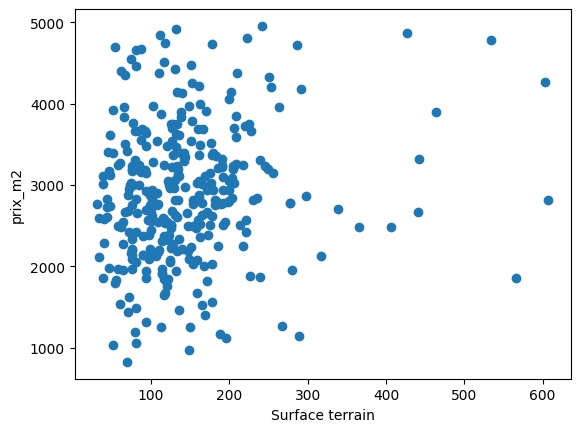

In [44]:
plt.scatter(df_maison_num_fea['Surface terrain'],df_maison_num_fea['prix_m2'])
plt.xlabel('Surface terrain')
plt.ylabel('prix_m2')
plt.show()

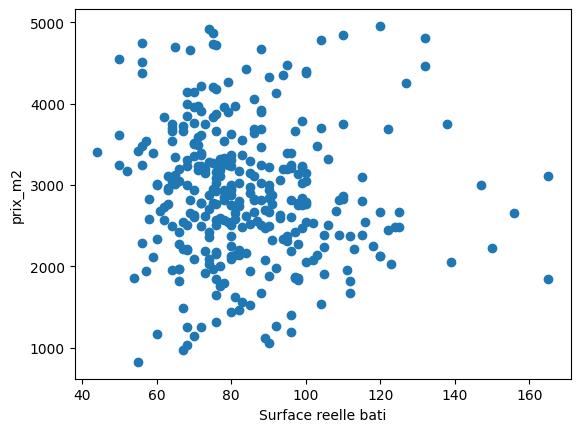

In [45]:
plt.scatter(df_maison_num_fea['Surface reelle bati'],df_maison_num_fea['prix_m2'])
plt.xlabel('Surface reelle bati')
plt.ylabel('prix_m2')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
from sklearn.preprocessing import StandardScaler

## 7.

### Appart

In [48]:
# X, y calculation
X_appart = df_appart_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_appart = df_appart_to_process[['prix_m2']]

In [49]:
X_appart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 394 to 10447
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        49 non-null     float64
 1   Nombre pieces principales  49 non-null     float64
 2   Surface terrain            49 non-null     float64
 3   Nombre de lots             49 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.9 KB


In [126]:
X_appart.shape

(49, 4)

In [50]:
# Splitting train & test data
Xa_train,  Xa_test, ya_train, ya_test = train_test_split(X_appart,y_appart,test_size = 0.2, random_state=42)

In [51]:
# Standardization
ScalerXa = StandardScaler()
Scalerya = StandardScaler()

In [52]:
# train data
Xa_train_scaled = ScalerXa.fit_transform(Xa_train)
ya_train_scaled = Scalerya.fit_transform(ya_train)

# test data
Xa_test_scaled = ScalerXa.transform(Xa_test)
ya_test_scaled = Scalerya.transform(ya_test)

### Maison

In [53]:
X_maison = df_maison_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_maison = df_maison_to_process[['prix_m2']]

In [127]:
X_maison.shape

(326, 4)

In [54]:
X_maison.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 18 to 11353
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        326 non-null    float64
 1   Nombre pieces principales  326 non-null    float64
 2   Surface terrain            326 non-null    float64
 3   Nombre de lots             326 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 12.7 KB


In [55]:
Xm_train,  Xm_test, ym_train, ym_test = train_test_split(X_maison,y_maison,test_size = 0.2, random_state=42)

In [56]:
ScalerXm = StandardScaler()
Scalerym = StandardScaler()
# train data
Xm_train_scaled = ScalerXm.fit_transform(Xm_train)
ym_train_scaled = Scalerym.fit_transform(ym_train)

# test data
Xm_test_scaled = ScalerXm.transform(Xm_test)
ym_test_scaled = Scalerym.transform(ym_test)

## 8. scikit-learn models

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [58]:
lg = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lg, dt, rf]

In [59]:
def get_pred_model(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [60]:
def eval_model(y_test, y_pred):
    return mean_squared_error(y_test,y_pred)

### Appart

In [103]:
models_metrics_appart = {}


In [104]:
pred_a = []
mse_a = []

for model in models:
    model.fit(Xa_train_scaled,ya_train_scaled)
    pred = get_pred_model(model,Xa_test_scaled)
    pred_a.append(pred)
    mse = eval_model(ya_test_scaled, pred)
    mse_a.append(mse)
    name_model = model.__class__.__name__
    models_metrics_appart[name_model] = (model,mse)

mse_a

c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.8669959900088646, 0.4514233068723569, 0.24744437956950344]

In [105]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.8669959900088646),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.4514233068723569),
 'RandomForestRegressor': (RandomForestRegressor(), 0.24744437956950344)}

### Maison

In [106]:
models_metrics_maison = {}

In [107]:
pred_m = []
mse_m = []
for model in models:
    model.fit(Xm_train_scaled,ym_train_scaled)
    pred = get_pred_model(model,Xm_test_scaled)
    pred_m.append(pred)
    mse = eval_model(ym_test_scaled, pred)
    mse_m.append(mse)
    name_model = model.__class__.__name__
    models_metrics_maison[name_model] = (model,mse)

mse_m


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.8649826558371496, 2.1981290957599335, 1.222630348955114]

In [108]:
models_metrics_maison


{'LinearRegression': (LinearRegression(), 0.8649826558371496),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.1981290957599335),
 'RandomForestRegressor': (RandomForestRegressor(), 1.222630348955114)}

## 9. GridSearchCV

In [67]:
from sklearn.model_selection import GridSearchCV

### Appart

In [109]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xa_train_scaled, ya_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ya_test_scaled, best_dt.predict(Xa_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "Optimized"
models_metrics_appart[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xa_train_scaled, ya_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ya_test_scaled, best_rf.predict(Xa_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "Optimized"
models_metrics_appart[name_model] = (best_rf,mse)


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [110]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.8669959900088646),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.4514233068723569),
 'RandomForestRegressor': (RandomForestRegressor(), 0.24744437956950344),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  0.542259927589573),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, random_state=42),
  0.21725535527204604)}

### Maison

In [111]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xm_train_scaled, ym_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ym_test_scaled, best_dt.predict(Xm_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "Optimized"
models_metrics_maison[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xm_train_scaled, ym_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ym_test_scaled, best_rf.predict(Xm_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "Optimized"
models_metrics_maison[name_model] = (best_rf,mse)


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [71]:
models_metrics_maison

{'LinearRegression': (LinearRegression(), 0.8649826558371496),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.383065941589281),
 'RandomForestRegressor': (RandomForestRegressor(), 1.2073148204703763),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.128891885397799),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
  1.0350889352792056)}

## 10. XGBRegressor

In [72]:
import xgboost as xgb

In [73]:
# extract categorical features
#cat_features = X.select_dtypes(exclude = np.number).colimns.tolist()
#for col in cat_features:
#   X[col] = X[col].astype('category')

### Appart

In [74]:
# Create matrices
dm_train_a = xgb.DMatrix(Xa_train_scaled,ya_train_scaled)
dm_test_a = xgb.DMatrix(Xa_test_scaled,ya_test_scaled)

In [75]:
# Define hyperparameters
params = {"objective": "reg:squarederror",
          'eval_metric': 'rmse',
          "tree_method": "hist"}

n = 100
evals = [(dm_test_a, "validation"), (dm_train_a, "train")]

evals_result = {}

model = xgb.train(
   params=params,
   dtrain=dm_train_a,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   # Activate early stopping
   early_stopping_rounds=10,
   evals_result=evals_result  # ← clé pour récupérer les métriques
)



[0]	validation-rmse:0.69666	train-rmse:0.78166
[10]	validation-rmse:0.53730	train-rmse:0.09250
[20]	validation-rmse:0.56062	train-rmse:0.02082
[30]	validation-rmse:0.56253	train-rmse:0.00577
[40]	validation-rmse:0.56315	train-rmse:0.00153
[50]	validation-rmse:0.56317	train-rmse:0.00110
[60]	validation-rmse:0.56317	train-rmse:0.00110
[63]	validation-rmse:0.56317	train-rmse:0.00110


In [76]:
rmse_list = evals_result["validation"]["rmse"]
best_rmse = rmse_list[model.best_iteration]
best_mse = best_rmse ** 2
print(f"Best RMSE: {best_rmse}")
print(f"Best MSE: {best_mse}")

Best RMSE: 0.5631716038348863
Best MSE: 0.3171622553659581


In [77]:
ypred= model.predict(dm_test_a)
mse=mean_squared_error(ya_test_scaled,ypred)

In [78]:
mse

0.3171622607458672

In [79]:
model_name = model.__class__.__name__
model_name

'Booster'

#### en utilisant l’API scikit-learn de XGBoost

In [112]:
from xgboost import XGBRegressor

model_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=100, early_stopping_rounds=10
)


model_regressor.fit(Xa_train_scaled, ya_train_scaled, eval_set=[(Xa_test_scaled,ya_test_scaled)])
ypred_regressor = model_regressor.predict(Xa_test_scaled)
mse_regressor = mean_squared_error(ya_test_scaled,ypred_regressor)
mse_regressor

[0]	validation_0-rmse:0.69666
[1]	validation_0-rmse:0.55976
[2]	validation_0-rmse:0.50477
[3]	validation_0-rmse:0.48104
[4]	validation_0-rmse:0.48837
[5]	validation_0-rmse:0.45678
[6]	validation_0-rmse:0.48026
[7]	validation_0-rmse:0.50112
[8]	validation_0-rmse:0.51401
[9]	validation_0-rmse:0.52694
[10]	validation_0-rmse:0.53730
[11]	validation_0-rmse:0.54620
[12]	validation_0-rmse:0.54884
[13]	validation_0-rmse:0.55195
[14]	validation_0-rmse:0.55370
[15]	validation_0-rmse:0.55467


0.20864460313994515

In [113]:
model_name = model_regressor.__class__.__name__
model_name

'XGBRegressor'

In [114]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.8669959900088646),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.4514233068723569),
 'RandomForestRegressor': (RandomForestRegressor(), 0.24744437956950344),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  0.542259927589573),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, random_state=42),
  0.21725535527204604)}

In [115]:
models_metrics_appart[model_name]=(model_regressor,mse_regressor)

In [116]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.8669959900088646),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.4514233068723569),
 'RandomForestRegressor': (RandomForestRegressor(), 0.24744437956950344),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  0.542259927589573),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, random_state=42),
  0.21725535527204604),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None,

### Maison 

In [117]:
from xgboost import XGBRegressor

model_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=100, early_stopping_rounds=10
)


model_regressor.fit(Xm_train_scaled, ym_train_scaled, eval_set=[(Xm_test_scaled,ym_test_scaled)])
ypred_regressor = model_regressor.predict(Xm_test_scaled)
mse_regressor = mean_squared_error(ym_test_scaled,ypred_regressor)
mse_regressor
model_name = model_regressor.__class__.__name__
model_name
models_metrics_maison[model_name]=(model_regressor,mse_regressor)
models_metrics_maison

[0]	validation_0-rmse:0.92364
[1]	validation_0-rmse:0.93089
[2]	validation_0-rmse:0.95618
[3]	validation_0-rmse:0.98909
[4]	validation_0-rmse:0.99327
[5]	validation_0-rmse:1.00731
[6]	validation_0-rmse:1.00544
[7]	validation_0-rmse:1.00875


[8]	validation_0-rmse:1.01964
[9]	validation_0-rmse:1.02179


{'LinearRegression': (LinearRegression(), 0.8649826558371496),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.1981290957599335),
 'RandomForestRegressor': (RandomForestRegressor(), 1.222630348955114),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.128891885397799),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
  1.0350889352792056),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_c

<class 'float'> 1
LinearRegression
<class 'float'> 0.8669959900088646
DecisionTreeRegressor
<class 'float'> 0.4514233068723569
RandomForestRegressor
<class 'float'> 0.24744437956950344
<class 'float'> 0.24744437956950344
RandomForestRegressorOptimized
<class 'float'> 0.21725535527204604
XGBRegressor


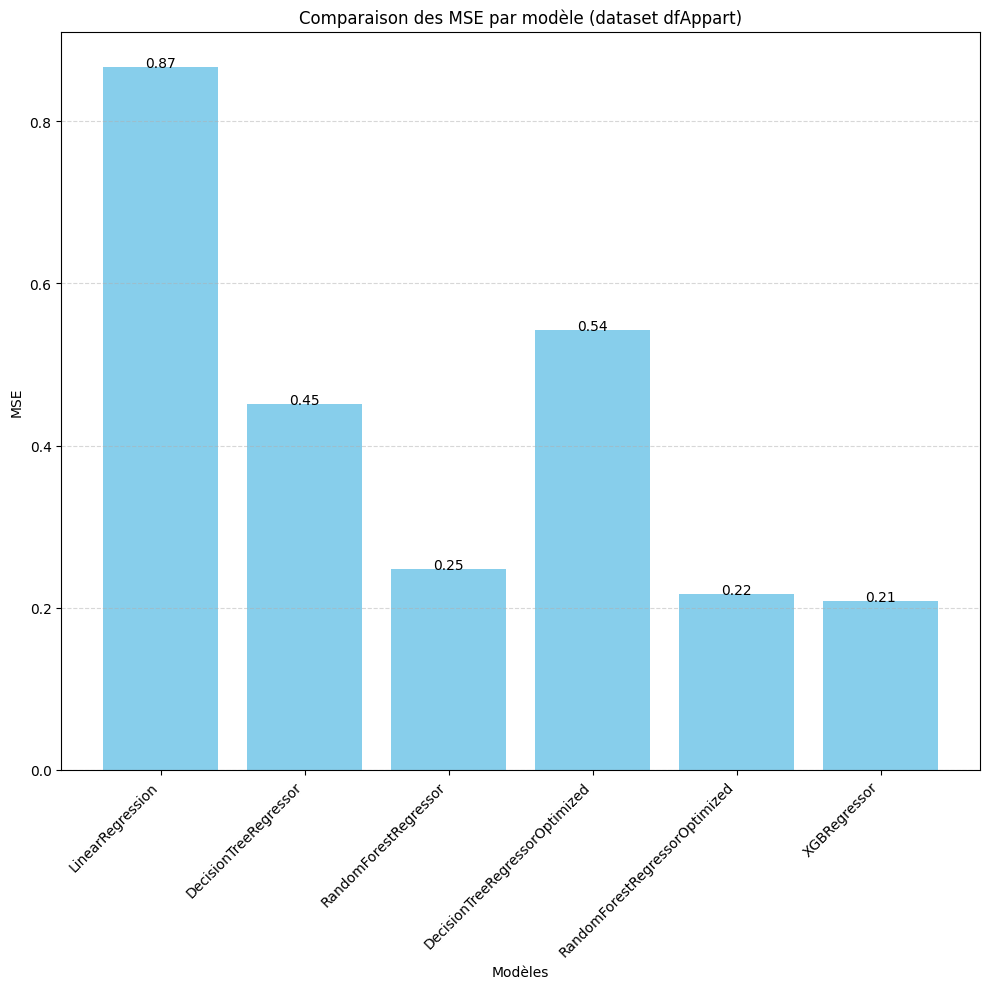

In [118]:
min_mse = 1
best_model = ""
mse_list=[]
for key in models_metrics_appart.keys():
    print(type(models_metrics_appart[key][1]), min_mse)
    mse_list.append(models_metrics_appart[key][1])
    msek = models_metrics_appart[key][1]
    if msek < min_mse:
        print(key)
        min_mse = models_metrics_appart[key][1]
        best_model_a = key


labels = list(models_metrics_appart.keys())
x = range(len(labels))  # positions numériques

plt.figure(figsize=(10, 10))
bars = plt.bar(x, mse_list, color='skyblue')

plt.title("Comparaison des MSE par modèle (dataset dfAppart)")


plt.ylabel("MSE")
plt.xlabel("Modèles")

plt.xticks(x, labels, rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        height ,                        # Y position (just above bar)
        f'{height:.2f}',                     # Format to 2 decimal places
        ha='center'
    )
plt.tight_layout()
plt.show()

In [119]:
min_mse = 1
best_model = ""
mse_list=[]
for key in models_metrics_maison.keys():
    print(type(models_metrics_maison[key][1]), min_mse)
    mse_list.append(models_metrics_maison[key][1])
    msek = models_metrics_maison[key][1]
    if msek < min_mse:
        print(key)
        min_mse = models_metrics_maison[key][1]
        best_model_m = key 

<class 'float'> 1
LinearRegression
<class 'float'> 0.8649826558371496
<class 'float'> 0.8649826558371496
<class 'float'> 0.8649826558371496
<class 'float'> 0.8649826558371496
<class 'float'> 0.8649826558371496
XGBRegressor


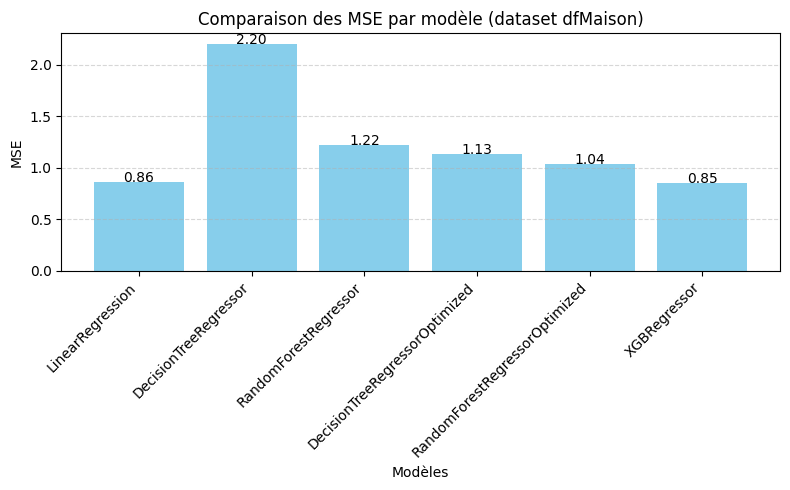

In [120]:

labels = list(models_metrics_maison.keys())
x = range(len(labels))  # positions numériques

plt.figure(figsize=(8, 5))
bars = plt.bar(x, mse_list, color='skyblue')
plt.title("Comparaison des MSE par modèle (dataset dfMaison)")
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        height ,                        # Y position (just above bar)
        f'{height:.2f}',                     # Format to 2 decimal places
        ha='center'
    )
plt.ylabel("MSE")
plt.xlabel("Modèles")
plt.xticks(x, labels, rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [121]:
best_model_a

'XGBRegressor'

In [122]:

best_model_m

'XGBRegressor'

In [123]:
Xa_train_scaled.shape

(39, 4)

In [124]:
Xm_train_scaled.shape

(260, 4)

# Save models

In [93]:
import joblib

In [125]:
# Save model and scaler
# Créer le dossier s'il n'existe pas
os.makedirs('../models', exist_ok=True)
joblib.dump({'model_a': models_metrics_appart[best_model_a][0], 
             'scaler_Xa': ScalerXa, 
             'scaler_ya':Scalerya,
             'model_m': models_metrics_maison[best_model_m][0], 
             'scaler_Xm': ScalerXm, 
             'scaler_ym':Scalerym}, 
            '../models/best_model_lille.pkl')

['../models/model_lille.pkl']

In [ ]:
dict_model_appart={}
for model_name in models_metrics_appart:
    dict_model_appart[model_name] = models_metrics_appart[model_name][0]
    

In [130]:
dict_model_appart

{'LinearRegression': LinearRegression(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'RandomForestRegressor': RandomForestRegressor(),
 'DecisionTreeRegressorOptimized': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
 'RandomForestRegressorOptimized': RandomForestRegressor(max_depth=10, random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              mono

In [131]:
joblib.dump(dict_model_appart,'../models/models_appart_lille.pkl')

['../models/models_appart_lille.pkl']

In [132]:
dict_model_maison={}
for model_name in models_metrics_maison:
    dict_model_maison[model_name] = models_metrics_maison[model_name][0]

In [133]:
dict_model_maison

{'LinearRegression': LinearRegression(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'RandomForestRegressor': RandomForestRegressor(),
 'DecisionTreeRegressorOptimized': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
 'RandomForestRegressorOptimized': RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=na

In [134]:
joblib.dump(dict_model_maison, '../models/models_maison_lille.pkl')

['../models/models_maison_lille.pkl']